## Data Ingestion

In [ ]:
# ! wget https://raw.githubusercontent.com/TemaBlag/21vek_user_query_classification/main/data/categories.csv
# ! wget https://raw.githubusercontent.com/TemaBlag/21vek_user_query_classification/main/data/sample_submission.csv
# ! wget https://raw.githubusercontent.com/TemaBlag/21vek_user_query_classification/main/data/train.csv
# ! wget https://raw.githubusercontent.com/TemaBlag/21vek_user_query_classification/main/data/test.csv

In [ ]:
# ! pip install pymorphy2 fasttext huggingface_hub inspect2

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
import os
from huggingface_hub import login
import getpass
import pymorphy2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import fasttext
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
import inspect2
import pymorphy2.units.base
from tqdm.notebook import tqdm

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
pymorphy2.units.base.inspect = inspect2

In [ ]:
os.environ["HF_TOKEN"] = getpass.getpass("Введите ваш Hugging Face токен: ")
login(token=os.getenv("HF_TOKEN"))

Введите ваш Hugging Face токен: ··········


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
df_categories = pd.read_csv('categories.csv')
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
df_sample_subm = pd.read_csv('sample_submission.csv')

In [ ]:
df_train.head()

,ID,CategoryID,Query
0,1,1,edifier
1,2,2,умная колонка яндекс станция лайт
2,3,3,чехол iphone 14 pro
3,4,4,zte
4,5,5,ноутбук huawei matebook b3-520 53012kfg


In [ ]:
len(df_train)

11558

In [ ]:
len(df_test)

3899

## Exploratory Data Analysis

In [ ]:
sum(df_train.CategoryID.isna())

0

In [ ]:
sum(df_train.Query == "")

0

In [ ]:
lengths_of_queries = np.array([len(val) for val in df_train.Query.values])

In [ ]:
print(f"Максимальная длина запроса: {np.max(lengths_of_queries)}")

Максимальная длина запроса: 132


In [ ]:
print(f"Средняя длина запроса: {np.mean(lengths_of_queries)}")

Средняя длина запроса: 32.79122685585742


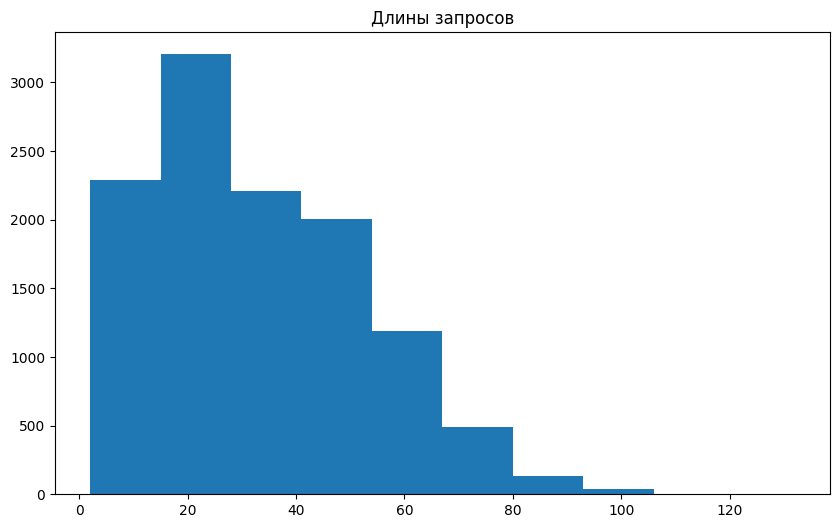

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(lengths_of_queries)
plt.title('Длины запросов')
plt.show()

In [ ]:
query_text = " ".join(df_train.Query.values[:30]).lower()

In [ ]:
query_text

'edifier умная колонка яндекс станция лайт чехол iphone 14 pro zte ноутбук huawei matebook b3-520 53012kfg мультимедиа акустика sven ms-2050bl ssd samsung 870 evo 500gb кабели, переходники baseus переходник сетевой robiton travelenergy держатели для смартфонов авто tcl защитное стекло для iphone 12 mini батареи для ибп 1207 мобильный телефон nokia 150 ds / та-1582 (черный) защитное стекло для телефона case antistatic для redmi note 13 (черный) адаптер atcom at6851 displayport(m) - vga(f) (0.1м) смартфон xiaomi redmi note 12 pro 8gb/256gb (polar white) бокс для жесткого диска gembird ee2-u3s-55 батарейка camelion 6lr61 plus alkaline bl-1 / 6lr61-bp1 venso радиочасы soundmax sm-1520b (черный/зеленый) умные часы детские prolike plsw02pp (сиреневый) ремешок для mi band 6 материнская плата msi pro z790-a max wifi 21 век защитное стекло apple 11 pro смартфон apple iphone 15 pro 512gb a3102 / a3101\xa0(белый титан) мыши и клавиатуры defender держатель для смартфонов xiaomi mi wireless car cha

In [ ]:
text = " ".join(df_train.Query.values).lower()
words = re.findall(r'\b\w+\b', text)
word_counts = Counter(words)

print(word_counts.most_common(20))

[('для', 1460), ('черный', 1182), ('чехол', 700), ('xiaomi', 591), ('pro', 552), ('смартфон', 541), ('кабель', 539), ('наушники', 487), ('samsung', 486), ('iphone', 452), ('redmi', 432), ('телевизор', 406), ('apple', 390), ('ноутбук', 379), ('на', 373), ('usb', 341), ('мышь', 339), ('128gb', 330), ('белый', 303), ('256gb', 291)]


In [ ]:
category_id_to_name = dict(zip(df_categories['CategoryID'], df_categories['CategoryName']))

In [ ]:
category_name_to_id = {v: k for k, v in category_id_to_name.items()}
n_classes = len(category_id_to_name)

In [ ]:
category_id_to_name

{0: 'Монитор',
 1: 'Мультимедиа акустика',
 2: 'Портативная акустика',
 3: 'Чехол/защитное стекло для телефона',
 4: 'Мобильный телефон',
 5: 'Ноутбук',
 6: 'Жесткий диск/SSD',
 7: 'Кабель',
 8: 'Сетевой фильтр/удлинитель',
 9: 'Держатель/док-станция для порт. устройств',
 10: 'Телевизор',
 11: 'Источник бесперебойного питания',
 12: 'Бокс/док-станция для накопителей',
 13: 'Элемент питания',
 14: 'Наушники/гарнитура',
 15: 'Радиочасы/метеостанция',
 16: 'Умные часы',
 17: 'Аксессуар для умных часов',
 18: 'Материнская плата',
 19: 'Сумка/чехол для ноутбука',
 20: 'Мышь/клавиатура',
 21: 'Планшет',
 22: 'USB flash',
 23: 'Беспроводная точка доступа',
 24: 'Игровая приставка',
 25: 'ЗУ/адаптер для портативных устройств',
 26: 'Кронштейн/стойка',
 27: 'Корпус для компьютера',
 28: 'Игра для игровой консоли',
 29: 'Кулер для компьютера',
 30: 'Карта памяти',
 31: 'Игровой контроллер',
 32: 'Портативное зарядное устройство',
 33: 'Фотоаппарат',
 34: 'Чехол/бампер для планшета',
 35: 'Камер

In [ ]:
for i in range(5):
    print(f"Query: {df_train.Query.iloc[i]}; Answer: {df_train.CategoryID.iloc[i]}")

Query: edifier; Answer: 1
Query: умная колонка яндекс станция лайт; Answer: 2
Query: чехол iphone 14 pro; Answer: 3
Query: zte; Answer: 4
Query: ноутбук huawei matebook b3-520 53012kfg; Answer: 5


In [ ]:
for i in range(10):
    print(f"Query: {df_train.Query.iloc[i]}; Answer: {category_id_to_name[df_train.CategoryID.iloc[i]]}")

Query: edifier; Answer: Мультимедиа акустика
Query: умная колонка яндекс станция лайт; Answer: Портативная акустика
Query: чехол iphone 14 pro; Answer: Чехол/защитное стекло для телефона
Query: zte; Answer: Мобильный телефон
Query: ноутбук huawei matebook b3-520 53012kfg; Answer: Ноутбук
Query: мультимедиа акустика sven ms-2050bl; Answer: Мультимедиа акустика
Query: ssd samsung 870 evo 500gb; Answer: Жесткий диск/SSD
Query: кабели, переходники baseus; Answer: Кабель
Query: переходник сетевой robiton travelenergy; Answer: Сетевой фильтр/удлинитель
Query: держатели для смартфонов авто; Answer: Держатель/док-станция для порт. устройств


In [ ]:
category_percentages = df_train['CategoryID'].value_counts(normalize=True) * 100
print(category_percentages)

CategoryID
3     11.282229
4     10.538155
7      9.422045
20     7.674338
14     6.393840
        ...    
61     0.043260
65     0.043260
47     0.034608
64     0.025956
66     0.025956
Name: proportion, Length: 66, dtype: float64


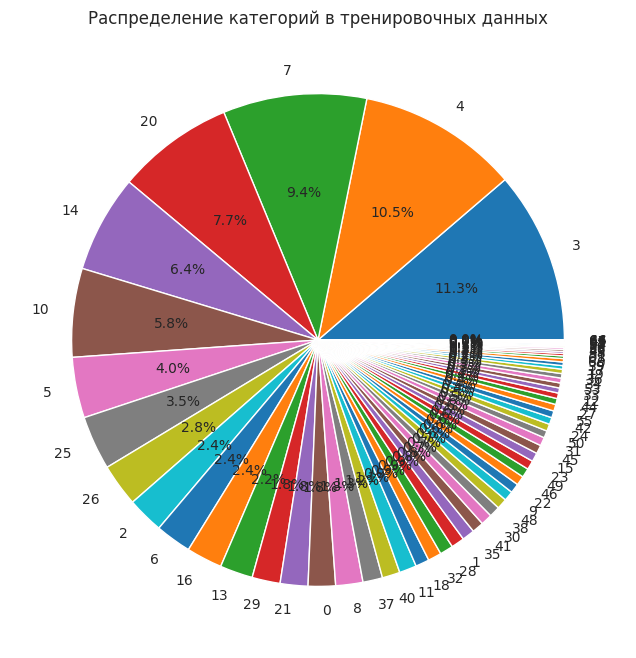

In [ ]:
category_counts = df_train['CategoryID'].value_counts()

plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Распределение категорий в тренировочных данных')
plt.show()

## Feature Engineering

In [ ]:
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = ['для', 'на', 'и']


def preprocess_text(text, lemmatize=True, remove_stopwords=False):
    text = str(text).lower()
    text = re.sub(r'[^a-zа-я0-9ё\s-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    if lemmatize:
        words = text.split()
        lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
        text = " ".join(lemmatized_words)

    if remove_stopwords:
        words = text.split()
        words = [word for word in words if word not in russian_stopwords]
        text = " ".join(words)
    return text

In [ ]:
df_train['Query_Lemma'] = df_train['Query'].apply(lambda x: preprocess_text(x, lemmatize=True, remove_stopwords=True))
df_test['Query_Lemma'] = df_test['Query'].apply(lambda x: preprocess_text(x, lemmatize=True, remove_stopwords=True))

In [ ]:
len(np.unique(" ".join(df_train['Query_Lemma']).split()))

9382

In [ ]:
X = df_train['Query_Lemma']
y = df_train['CategoryID']

X_train_lemma, X_val_lemma, y_train_lemma, y_val_lemma = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [ ]:
X = df_train['Query']
y = df_train['CategoryID']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Train set size: 9246
Validation set size: 2312


In [ ]:
print("Обычные запросы:")
for i, query in enumerate(df_train['Query'].head(), start=1):
    print(f"{i}. {query}")
print("Лемматизированные запросы:")
for i, query in enumerate(df_train['Query_Lemma'].head(), start=1):
    print(f"{i}. {query}")

Обычные запросы:
1. edifier
2. умная колонка яндекс станция лайт
3. чехол iphone 14 pro
4. zte
5. ноутбук huawei matebook b3-520 53012kfg
Лемматизированные запросы:
1. edifier
2. умный колонка яндекс станция лайта
3. чехол iphone 14 pro
4. zte
5. ноутбук huawei matebook b3-520 53012kfg


## TF-IDF + Logistic Regression

In [ ]:
tfidf_logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9, sublinear_tf=True)),
    ('clf', LogisticRegression(solver='liblinear', class_weight='balanced', C=1.0, random_state=seed))
])

tfidf_logreg_pipeline.fit(X_train_lemma, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='liblinear'))])

In [ ]:
y_pred_val_logreg = tfidf_logreg_pipeline.predict(X_val_lemma)
macro_f1_logreg = f1_score(y_val, y_pred_val_logreg, average='macro', zero_division=0)
print(f"TF-IDF + LogReg Validation Macro F1: {macro_f1_logreg:.4f}")

TF-IDF + LogReg Validation Macro F1: 0.8414


## FastText

In [ ]:
# ! pip install numpy==1.24.4

In [ ]:
class MyDataset(Dataset):
    def __init__(self, texts, labels, transform=False, p_transform=0.8, p_permutation=0.6):
        self.texts = texts
        self.labels = labels
        self.transform = transform
        self.p_transform = p_transform
        self.p_permutation = p_permutation

    def __len__(self):
        return len(self.texts)

    # augmentations
    def word_permutation(self, text):
        len_text = len(text)
        if len_text > 1:
            idx1 = np.random.randint(0, len_text)
            idx2 = np.random.randint(0, len_text)
            while idx1 == idx2:
                idx2 = np.random.randint(0, len_text)
            text[idx1], text[idx2] = text[idx2], text[idx1]
        return text

    def delete_word(self, text):
        len_text = len(text)
        if len_text > 1:
            idx = np.random.randint(0, len_text)
            del text[idx]
        return text

    def augment_text(self, text):
        text = text.copy()
        if np.random.rand() < self.p_permutation:
            text = self.word_permutation(text)
        else:
            text = self.delete_word(text)
        return text

    def __getitem__(self, idx):
        text = self.texts[idx].strip().split()
        if self.transform and np.random.rand() < self.p_transform:
            text = self.augment_text(text)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return text, label

In [ ]:
def create_fasttext_file_from_dataset(dataset, filepath, repeats=1):
    with open(filepath, 'w', encoding='utf-8') as f:
        for _ in range(repeats):
            for text, label in tqdm(dataset, desc=f"Writing {filepath} (pass {_+1})"):
                if isinstance(text, list):
                    text = ' '.join(text)
                line = f"__label__{label} {text.replace(chr(10), ' ')}\n"
                f.write(line)

In [ ]:
dataset = MyDataset(
    X_train_lemma.tolist(),
    y_train_lemma.tolist(),
    transform=True,
    p_transform=0.8,
    p_permutation=0.6
)

In [ ]:
create_fasttext_file_from_dataset(dataset, 'fasttext_train.txt', repeats=3)

Writing fasttext_train.txt (pass 1):   0%|          | 0/9246 [00:00<?, ?it/s]

Writing fasttext_train.txt (pass 2):   0%|          | 0/9246 [00:00<?, ?it/s]

Writing fasttext_train.txt (pass 3):   0%|          | 0/9246 [00:00<?, ?it/s]

In [ ]:
def create_fasttext_file(df, filename, text_col, label_col):
    with open(filename, 'w', encoding='utf-8') as f:
        for index, row in df.iterrows():
            text = row[text_col]
            if isinstance(text, list):
                text = ' '.join(text)
            text = text.replace('\n', ' ')
            label = row[label_col]
            f.write(f"__label__{label} {text}\n")

In [ ]:
temp_val_df = pd.DataFrame({'text': X_val_lemma, 'label': y_val_lemma})
create_fasttext_file(temp_val_df, 'fasttext_val.txt', text_col='text', label_col='label')

In [ ]:
ft_model = fasttext.train_supervised(
    input='fasttext_train.txt',
    epoch=300,
    lr=0.154,
    wordNgrams=2,
    dim=128,
    loss='softmax',
    thread=4,
    seed=seed
)

In [ ]:
y_pred_val_ft = []
for line in X_val_lemma:
    pred_label, _ = ft_model.predict(line)
    y_pred_val_ft.append(int(pred_label[0].replace('__label__', '')))

macro_f1_ft = f1_score(y_val, y_pred_val_ft, average='macro', zero_division=0)
print(f"FastText Validation Macro F1: {macro_f1_ft:.4f}")

FastText Validation Macro F1: 0.8531


In [ ]:
temp_train_df = pd.DataFrame({'text': X_train_lemma, 'label': y_train_lemma})
temp_val_df = pd.DataFrame({'text': X_val_lemma, 'label': y_val_lemma})

In [ ]:
def create_fasttext_file(df, text_col, label_col, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            f.write(f"__label__{row[label_col]} {row[text_col]}\n")

In [ ]:
create_fasttext_file(temp_train_df, 'text', 'label', 'fasttext_train.txt')
create_fasttext_file(temp_val_df, 'text', 'label', 'fasttext_val.txt')

In [ ]:
ft_model = fasttext.train_supervised(
    input='fasttext_train.txt',
    epoch=177,
    lr=0.154,
    wordNgrams=2,
    dim=128,
    loss='softmax',
    thread=4,
    seed=seed
)

In [ ]:
y_pred_val_ft = []
for line in X_val_lemma:
    pred_label, _ = ft_model.predict(line)
    y_pred_val_ft.append(int(pred_label[0].replace('__label__', '')))

macro_f1_ft = f1_score(y_val, y_pred_val_ft, average='macro', zero_division=0)
print(f"FastText Validation Macro F1: {macro_f1_ft:.4f}")

FastText Validation Macro F1: 0.8702


In [ ]:
y_pred_val_ft = {}
for index, query in zip(df_test.ID.values, df_test.Query_Lemma.values):
    pred_label, _ = ft_model.predict(query)
    y_pred_val_ft[index] = int(pred_label[0].replace('__label__', ''))

In [ ]:
df_subm = pd.DataFrame(list(y_pred_val_ft.items()), columns=['ID', 'CategoryID'])
df_subm = df_subm.reset_index(drop=True)
df_subm.to_csv('submission.csv', index=False)

## FastText + NN

In [ ]:
import fasttext
import pickle

def create_fasttext_file(df, text_col, label_col, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            f.write(f"__label__{row[label_col]} {row[text_col]}\n")

temp_train_df = pd.DataFrame({'text': X_train_lemma, 'label': y_train_lemma})
temp_val_df = pd.DataFrame({'text': X_val_lemma, 'label': y_val_lemma})

create_fasttext_file(temp_train_df, 'text', 'label', 'fasttext_train.txt')
create_fasttext_file(temp_val_df,   'text', 'label', 'fasttext_val.txt')

ft_model = fasttext.train_supervised(
    input='fasttext_train.txt',
    epoch=200,
    lr=0.1,
    wordNgrams=3,
    dim=128,
    loss='softmax',
    thread=4,
    seed=seed
)

ft_model.save_model('ft_supervised.bin')
with open('ft_vocab.pkl', 'wb') as f:
    pickle.dump(ft_model.get_words(), f)

In [ ]:
from torch.utils.data import Dataset
import torch

class FastTextTfidfDataset(Dataset):
    """
    Dataset, возвращает кортеж:
      - ft_vec: torch.FloatTensor [ft_dim]
      - tfidf_vec: torch.FloatTensor [tfidf_dim]
      - label: torch.LongTensor (scalar)
    """
    def __init__(self, texts, labels, tfidf_vectorizer, ft_model):
        self.texts = texts
        self.labels = labels
        self.tfidf = tfidf_vectorizer.transform(texts).toarray()
        self.ft_model = ft_model
        self.ft_dim = ft_model.get_dimension()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        vec = self.ft_model.get_sentence_vector(text)
        ft_vec = torch.tensor(vec, dtype=torch.float)
        tfidf_vec = torch.tensor(self.tfidf[idx], dtype=torch.float)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return ft_vec, tfidf_vec, label


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class HybridQueryClassifier(nn.Module):
    def __init__(self,
                 ft_dim: int,
                 tfidf_dim: int,
                 hidden_dim: int = 256,
                 n_classes: int = 67,
                 dropout_prob: float = 0.2):
        super().__init__()
        self.fc_ft = nn.Linear(ft_dim, hidden_dim)
        self.fc_tfidf = nn.Linear(tfidf_dim, hidden_dim)
        self.fc_combined = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.out = nn.Linear(hidden_dim, n_classes)

    def forward(self, ft_vecs, tfidf_vecs):
        h_ft = F.relu(self.fc_ft(ft_vecs))
        h_tfidf = F.relu(self.fc_tfidf(tfidf_vecs))
        h_cat = torch.cat([h_ft, h_tfidf], dim=1)
        h = F.relu(self.fc_combined(h_cat))
        h = self.dropout(h)
        return self.out(h)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import f1_score

tfidf_vec = TfidfVectorizer(max_features=5000)
tfidf_vec.fit(temp_train_df['text'])

train_ds = FastTextTfidfDataset(
    texts = temp_train_df['text'].tolist(),
    labels = temp_train_df['label'].tolist(),
    tfidf_vectorizer = tfidf_vec,
    ft_model = ft_model
)
val_ds = FastTextTfidfDataset(
    texts = temp_val_df['text'].tolist(),
    labels = temp_val_df['label'].tolist(),
    tfidf_vectorizer = tfidf_vec,
    ft_model = ft_model
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridQueryClassifier(
    ft_dim = ft_model.get_dimension(),
    tfidf_dim = 5000
).to(device)

batch_size = 32
num_epochs = 10
lr = 3e-5

optimizer = AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    verbose=True
)

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 100):
    model.train()
    for ft_vecs, tfidf_vecs, labels in train_loader:
        ft_vecs, tfidf_vecs, labels = ft_vecs.to(device), tfidf_vecs.to(device), labels.to(device)
        logits = model(ft_vecs, tfidf_vecs)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for ft_vecs, tfidf_vecs, labels in val_loader:
            ft_vecs, tfidf_vecs = ft_vecs.to(device), tfidf_vecs.to(device)
            out = model(ft_vecs, tfidf_vecs).argmax(dim=1).cpu().tolist()
            preds += out
            trues += labels.tolist()

    f1 = f1_score(trues, preds, average='macro', zero_division=0)
    scheduler.step(f1)
    print(f"Epoch {epoch} — Val macro-F1: {f1:.4f}")

Epoch 1 — Val macro-F1: 0.0415
Epoch 2 — Val macro-F1: 0.0370
Epoch 3 — Val macro-F1: 0.0579
Epoch 4 — Val macro-F1: 0.0683
Epoch 5 — Val macro-F1: 0.0715
Epoch 6 — Val macro-F1: 0.0756
Epoch 7 — Val macro-F1: 0.1091
Epoch 8 — Val macro-F1: 0.1697
Epoch 9 — Val macro-F1: 0.2145
Epoch 10 — Val macro-F1: 0.2391
Epoch 11 — Val macro-F1: 0.2647
Epoch 12 — Val macro-F1: 0.2867
Epoch 13 — Val macro-F1: 0.3278
Epoch 14 — Val macro-F1: 0.3769
Epoch 15 — Val macro-F1: 0.4185
Epoch 16 — Val macro-F1: 0.4463
Epoch 17 — Val macro-F1: 0.4698
Epoch 18 — Val macro-F1: 0.5088
Epoch 19 — Val macro-F1: 0.5300
Epoch 20 — Val macro-F1: 0.5357
Epoch 21 — Val macro-F1: 0.5505
Epoch 22 — Val macro-F1: 0.5882
Epoch 23 — Val macro-F1: 0.5998
Epoch 24 — Val macro-F1: 0.6071
Epoch 25 — Val macro-F1: 0.6310
Epoch 26 — Val macro-F1: 0.6427
Epoch 27 — Val macro-F1: 0.6635
Epoch 28 — Val macro-F1: 0.6876
Epoch 29 — Val macro-F1: 0.7072
Epoch 30 — Val macro-F1: 0.7126
Epoch 31 — Val macro-F1: 0.7155
Epoch 32 — Val ma

## Fasttext + TF-IDF + Catboost + augmentation + optuna

In [ ]:
# ! pip install optuna numpy==1.26.4 catboost

In [ ]:
class MyDataset(Dataset):
    def __init__(self, texts, labels, transform=False, p=0.5):
        self.texts = texts
        self.labels = labels
        self.transform = transform
        self.p = p

    def __len__(self):
        return len(self.texts)

    def word_permutation(self, text):
        len_text = len(text)
        if len_text > 1:
            idx1 = np.random.randint(0, len_text)
            idx2 = np.random.randint(0, len_text)
            while idx1 == idx2:
                idx2 = np.random.randint(0, len_text)
            text[idx1], text[idx2] = text[idx2], text[idx1]
        return text

    def delete_word(self, text):
        len_text = len(text)
        if len_text > 1:
            idx = np.random.randint(0, len_text)
            del text[idx]
        return text

    def augment_text(self, text):
        text = text.copy()
        if np.random.rand() < self.p:
            text = self.word_permutation(text)
        else:
            text = self.delete_word(text)
        return text

    def __getitem__(self, idx):
        text = self.texts[idx].strip().split()
        if self.transform:
            text = self.augment_text(text)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return text, label
dataset = MyDataset(X_train_lemma.tolist(), y_train_lemma.tolist(), transform=True, p=0.6)

In [ ]:
dataset = MyDataset(X_train_lemma.tolist(), y_train_lemma.tolist(), transform=True, p=0.6)

In [ ]:
def create_fasttext_file(df, text_col, label_col, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            f.write(f"__label__{row[label_col]} {row[text_col]}\n")

temp_train_df = pd.DataFrame({'text': X_train_lemma, 'label': y_train_lemma})
temp_val_df = pd.DataFrame({'text': X_val_lemma, 'label': y_val_lemma})

create_fasttext_file(temp_train_df, 'text', 'label', 'fasttext_train.txt')
create_fasttext_file(temp_val_df,   'text', 'label', 'fasttext_val.txt')

In [ ]:
import optuna
import fasttext

texts = X_val_lemma.tolist()
true_labels = y_val_lemma.tolist()

def objective(trial):
    epoch = trial.suggest_int('epoch', 50, 200)
    lr = trial.suggest_float('lr', 0.1, 0.2, log=True)
    wordNgrams = trial.suggest_int('wordNgrams', 1, 3)
    loss = trial.suggest_categorical('loss', ['softmax', 'hs'])
    dim = trial.suggest_categorical('dim', [64, 128, 256])
    try:
        model = fasttext.train_supervised(
            input='fasttext_train.txt',
            epoch=epoch,
            lr=lr,
            wordNgrams=wordNgrams,
            dim=dim,
            loss=loss,
            thread=4,
            seed=42
        )
        preds = []
        for text in texts:
            label = model.predict(text)[0][0]
            label_clean = label.replace("__label__", "")
            preds.append(float(label_clean))
        f1 = f1_score(true_labels, preds, average='macro')
    except RuntimeError as e:
        print(f"[ERROR] Trial failed with lr={lr}, dim={dim}: {str(e)}")
        f1 = 0.8
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Лучшие параметры:", study.best_params)
print("Лучшее качество (accuracy):", study.best_value)

[I 2025-05-15 13:31:59,676] A new study created in memory with name: no-name-b081b549-2085-44b9-9c37-b227b2fd6095
[I 2025-05-15 13:32:00,062] Trial 0 finished with value: 0.8 and parameters: {'epoch': 155, 'lr': 0.14343124175195496, 'wordNgrams': 1, 'loss': 'softmax', 'dim': 256}. Best is trial 0 with value: 0.8.


[ERROR] Trial failed with lr=0.14343124175195496, dim=256: Encountered NaN.


[I 2025-05-15 13:32:05,382] Trial 1 finished with value: 0.7950491029534856 and parameters: {'epoch': 103, 'lr': 0.12161156165501648, 'wordNgrams': 2, 'loss': 'hs', 'dim': 64}. Best is trial 0 with value: 0.8.
[I 2025-05-15 13:32:08,150] Trial 2 finished with value: 0.7828772588175934 and parameters: {'epoch': 62, 'lr': 0.1285127995964188, 'wordNgrams': 2, 'loss': 'hs', 'dim': 64}. Best is trial 0 with value: 0.8.
[I 2025-05-15 13:32:38,115] Trial 3 finished with value: 0.8444321588551599 and parameters: {'epoch': 103, 'lr': 0.12711418228256519, 'wordNgrams': 2, 'loss': 'softmax', 'dim': 128}. Best is trial 3 with value: 0.8444321588551599.
[I 2025-05-15 13:33:05,915] Trial 4 finished with value: 0.8394975431960366 and parameters: {'epoch': 157, 'lr': 0.10695917588763942, 'wordNgrams': 3, 'loss': 'softmax', 'dim': 64}. Best is trial 3 with value: 0.8444321588551599.
[I 2025-05-15 13:33:12,587] Trial 5 finished with value: 0.7971518398097581 and parameters: {'epoch': 153, 'lr': 0.100129

[ERROR] Trial failed with lr=0.15041729203678794, dim=128: Encountered NaN.


[I 2025-05-15 13:34:26,480] Trial 9 finished with value: 0.861775055576727 and parameters: {'epoch': 162, 'lr': 0.1706031135372337, 'wordNgrams': 2, 'loss': 'softmax', 'dim': 128}. Best is trial 9 with value: 0.861775055576727.
[I 2025-05-15 13:35:24,984] Trial 10 finished with value: 0.8581211332842706 and parameters: {'epoch': 193, 'lr': 0.19157885210623354, 'wordNgrams': 3, 'loss': 'softmax', 'dim': 128}. Best is trial 9 with value: 0.861775055576727.
[I 2025-05-15 13:36:22,975] Trial 11 finished with value: 0.8590990785414855 and parameters: {'epoch': 195, 'lr': 0.19917255912850187, 'wordNgrams': 3, 'loss': 'softmax', 'dim': 128}. Best is trial 9 with value: 0.861775055576727.
[I 2025-05-15 13:37:23,043] Trial 12 finished with value: 0.8547647544328095 and parameters: {'epoch': 197, 'lr': 0.1988483545633137, 'wordNgrams': 3, 'loss': 'softmax', 'dim': 128}. Best is trial 9 with value: 0.861775055576727.
[I 2025-05-15 13:38:18,032] Trial 13 finished with value: 0.8497533751283507 and

[ERROR] Trial failed with lr=0.1700444273948842, dim=128: Encountered NaN.


[I 2025-05-15 13:38:59,031] Trial 15 finished with value: 0.8625395153904081 and parameters: {'epoch': 133, 'lr': 0.18242088777070972, 'wordNgrams': 3, 'loss': 'softmax', 'dim': 128}. Best is trial 15 with value: 0.8625395153904081.
[I 2025-05-15 13:40:19,471] Trial 16 finished with value: 0.8531774221857643 and parameters: {'epoch': 135, 'lr': 0.1618958344559272, 'wordNgrams': 3, 'loss': 'softmax', 'dim': 256}. Best is trial 15 with value: 0.8625395153904081.
[I 2025-05-15 13:40:19,961] Trial 17 finished with value: 0.8 and parameters: {'epoch': 103, 'lr': 0.18046959697188097, 'wordNgrams': 1, 'loss': 'softmax', 'dim': 128}. Best is trial 15 with value: 0.8625395153904081.


[ERROR] Trial failed with lr=0.18046959697188097, dim=128: Encountered NaN.


[I 2025-05-15 13:40:44,006] Trial 18 finished with value: 0.8446867136573181 and parameters: {'epoch': 82, 'lr': 0.15814815497639603, 'wordNgrams': 2, 'loss': 'softmax', 'dim': 128}. Best is trial 15 with value: 0.8625395153904081.
[I 2025-05-15 13:41:55,587] Trial 19 finished with value: 0.8452540999336435 and parameters: {'epoch': 116, 'lr': 0.1811822932928536, 'wordNgrams': 3, 'loss': 'softmax', 'dim': 256}. Best is trial 15 with value: 0.8625395153904081.


Лучшие параметры: {'epoch': 133, 'lr': 0.18242088777070972, 'wordNgrams': 3, 'loss': 'softmax', 'dim': 128}
Лучшее качество (accuracy): 0.8625395153904081


In [ ]:
import optuna
import fasttext

texts = X_val_lemma.tolist()
true_labels = y_val_lemma.tolist()

def objective(trial):
    epoch = trial.suggest_int('epoch', 50, 200)
    lr = trial.suggest_float('lr', 0.1, 0.2, log=True)
    wordNgrams = trial.suggest_int('wordNgrams', 2, 3)
    try:
        model = fasttext.train_supervised(
            input='fasttext_train.txt',
            epoch=epoch,
            lr=lr,
            wordNgrams=wordNgrams,
            dim=128,
            loss='softmax',
            thread=4,
            seed=42
        )
        preds = []
        for text in texts:
            label = model.predict(text)[0][0]
            label_clean = label.replace("__label__", "")
            preds.append(float(label_clean))
        f1 = f1_score(true_labels, preds, average='macro')
    except RuntimeError as e:
        print(f"[ERROR] Trial failed with lr={lr}, dim={dim}: {str(e)}")
        f1 = 0.8
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Лучшие параметры:", study.best_params)
print("Лучшее качество (accuracy):", study.best_value)

[I 2025-05-15 13:44:00,752] A new study created in memory with name: no-name-331c0ceb-9770-4aa7-8239-366a15948235
[I 2025-05-15 13:44:54,945] Trial 0 finished with value: 0.8681637073353675 and parameters: {'epoch': 179, 'lr': 0.1469960319083042, 'wordNgrams': 3}. Best is trial 0 with value: 0.8681637073353675.
[I 2025-05-15 13:45:48,413] Trial 1 finished with value: 0.8485174207662912 and parameters: {'epoch': 189, 'lr': 0.10064744539217087, 'wordNgrams': 2}. Best is trial 0 with value: 0.8681637073353675.
[I 2025-05-15 13:46:08,874] Trial 2 finished with value: 0.8340404636944798 and parameters: {'epoch': 68, 'lr': 0.1470822161079641, 'wordNgrams': 3}. Best is trial 0 with value: 0.8681637073353675.
[I 2025-05-15 13:46:33,286] Trial 3 finished with value: 0.8330296926339901 and parameters: {'epoch': 78, 'lr': 0.15063507596431108, 'wordNgrams': 3}. Best is trial 0 with value: 0.8681637073353675.
[I 2025-05-15 13:47:10,472] Trial 4 finished with value: 0.8552052336580445 and parameters

Лучшие параметры: {'epoch': 177, 'lr': 0.1536209732947752, 'wordNgrams': 2}
Лучшее качество (accuracy): 0.8714174991593396


In [ ]:
ft_model = fasttext.train_supervised(
    input='fasttext_train.txt',
    epoch=177,
    lr=0.154,
    wordNgrams=2,
    dim=128,
    loss='softmax',
    thread=4,
    seed=seed
)

In [ ]:
texts = X_train_lemma.tolist()
tf_idf_model = TfidfVectorizer(max_features=5000, sublinear_tf=True)
X_tfidf = tf_idf_model.fit_transform(texts)

In [ ]:
X_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 40620 stored elements and shape (9246, 5000)>

In [ ]:
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import normalize

alpha = 1.0
beta = 0.25

classes = np.unique(y_train_lemma)
centroids = {}

for c in classes:
    idx_pos = np.where(y_train_lemma == c)[0]
    idx_neg = np.where(y_train_lemma != c)[0]

    v_pos = X_tfidf[idx_pos].mean(axis=0).A1
    v_neg = X_tfidf[idx_neg].mean(axis=0).A1

    mu_c = alpha * v_pos - beta * v_neg
    centroids[c] = mu_c

In [ ]:
for key, val in list(centroids.items())[:5]:
    print(f"{key}: {val}")

0: [[-6.49611994e-05 -2.37836686e-05 -5.48657433e-05 ... -9.99558844e-04
  -1.20003631e-05 -2.35135851e-05]]
1: [[-6.43517009e-05 -2.35605183e-05 -5.43509654e-05 ... -9.90180482e-04
  -1.18877697e-05 -2.32929689e-05]]
2: [[-6.53570848e-05 -2.39286106e-05 -5.52001052e-05 ...  1.07427814e-01
   1.97218637e-03  3.86431408e-03]]
3: [[-7.19063379e-05 -2.63264307e-05 -6.07315554e-05 ... -1.10642378e-03
  -1.32833472e-05 -2.60274720e-05]]
4: [[-7.13065389e-05 -2.61068316e-05 -6.02249697e-05 ... -1.09719467e-03
  -1.31725456e-05 -2.58103666e-05]]


In [ ]:
from scipy.special import softmax
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def count_probs_tf_idf(vector, centroids):
    class_labels = list(centroids.keys())
    centroid_matrix = np.vstack([centroids[c] for c in class_labels])
    similarities = cosine_similarity(vector.reshape(1, -1), centroid_matrix).flatten()
    probs = softmax(similarities)
    return probs

In [ ]:
count_probs_tf_idf(X_tfidf[1].toarray().flatten(), centroids)

array([0.01498757, 0.01495513, 0.01492941, 0.01638148, 0.01849708,
       0.0149486 , 0.01491685, 0.01491431, 0.01491172, 0.01606454,
       0.01506014, 0.01493223, 0.01496198, 0.01490354, 0.0152852 ,
       0.01556147, 0.01577504, 0.01518666, 0.01495325, 0.01495271,
       0.01489836, 0.01580254, 0.01495399, 0.01503656, 0.01503662,
       0.0151562 , 0.01492323, 0.01494761, 0.01492299, 0.0149099 ,
       0.0151473 , 0.01510868, 0.01544989, 0.01507983, 0.01622235,
       0.01550427, 0.01506168, 0.0151888 , 0.0149484 , 0.0149494 ,
       0.01495692, 0.01494171, 0.01495505, 0.01495609, 0.0156405 ,
       0.01495786, 0.01496538, 0.01498886, 0.01493496, 0.01495299,
       0.01494778, 0.01495185, 0.01496672, 0.01495556, 0.01497038,
       0.0149328 , 0.01496464, 0.01498435, 0.0149494 , 0.01496667,
       0.01495784, 0.0149724 , 0.01496348, 0.0149773 , 0.01497939,
       0.01498163])

In [ ]:
import re
from catboost import CatBoostClassifier
import os
import fasttext
import numpy as np
from scipy.sparse import hstack
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

def count_lang(text):
    ru = len(re.findall(r"\b[а-яА-ЯёЁ]+\b", text))
    en = len(re.findall(r"\b[a-zA-Z]+\b", text))
    return np.array([ru, en])

class QueryClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 tfidf_params=None,
                 ft_params=None,
                 catboost_params=None,
                 seed=42):
        self.tfidf = TfidfVectorizer(**(tfidf_params or {}))
        self.lr = LogisticRegression(random_state=seed)
        self.ft_params = ft_params or {}
        self.catboost = CatBoostClassifier(**(catboost_params or {}))
        self.le = LabelEncoder()
        self.ft_model = None
        self.weights = None
        self.meta_clf = LogisticRegression(
            solver='lbfgs',
            multi_class='multinomial',
            fit_intercept=False,
            C=1e6
        )

    def fit(self, X, y):
        y_enc = self.le.fit_transform(y)

        # TF-IDF + LR
        Xt = self.tfidf.fit_transform(X)
        self.lr.fit(Xt, y_enc)

        # FastText
        self.ft_model = fasttext.train_supervised(**self.ft_params)

        # Catboost
        ft_emb = np.vstack([self.ft_model.get_sentence_vector(t) for t in X])
        lang = np.vstack([count_lang(t) for t in X])
        Xc = hstack([Xt, ft_emb, lang]).tocsr()
        self.catboost.fit(Xc, y_enc)

        p1 = self.lr.predict_proba(Xt)

        probs = []
        for p in X:
            pred_labels, pred_probs = self.ft_model.predict(p, k=n_classes)
            current_numbers = [int(label.split('__')[-1]) for label in pred_labels]
            sorted_indices = np.argsort(current_numbers)
            sorted_probs = np.array(pred_probs)[sorted_indices]
            probs.append(sorted_probs)
        p2 = np.array(probs)
        p3 = self.catboost.predict_proba(Xc)

        X_meta = np.hstack([p1, p2, p3])
        self.meta_clf.fit(X_meta, y_enc)
        C = p1.shape[1]
        coefs = self.meta_clf.coef_

        w1 = np.mean(np.abs(coefs[:, :C]))
        w2 = np.mean(np.abs(coefs[:,  C:2*C]))
        w3 = np.mean(np.abs(coefs[:,2*C:]))
        self.weights = np.array([w1, w2, w3])
        self.weights /= self.weights.sum()
        return self

    def predict_proba(self, X):
        Xt = self.tfidf.transform(X)

        p1 = self.lr.predict_proba(Xt)

        ft_emb = np.vstack([self.ft_model.get_sentence_vector(t) for t in X])
        lang = np.vstack([count_lang(t) for t in X])
        Xc = hstack([Xt, ft_emb, lang]).tocsr()
        p3 = self.catboost.predict_proba(Xc)

        labels = [l.replace('__label__', '') for l in self.ft_model.labels]
        idx = self.le.transform(labels)
        p2_raw = [self.ft_model.predict(p, k=len(self.le.classes_))[1] for p in X]
        p2 = np.zeros_like(p1)
        for i, probs in enumerate(p2_raw):
            p2[i, idx] = probs

        w = self.weights / self.weights.sum()
        return w[0]*p1 + w[1]*p2 + w[2]*p3

    def predict(self, X):
        probas = self.predict_proba(X)
        return self.le.inverse_transform(probas.argmax(axis=1))

In [ ]:
tfidf_params = {
    'max_features': 5000,
    'sublinear_tf': True
}

ft_params = {
    'input': 'fasttext_train.txt',
    'epoch': 177,
    'lr': 0.154,
    'wordNgrams': 2,
    'dim': 128,
    'loss': 'softmax',
    'thread': 4,
    'seed': seed
}

catboost_params = {
    'iterations': 100,
    'loss_function': 'MultiClass',
    'random_seed': seed,
    'early_stopping_rounds': 50,
    'auto_class_weights': 'Balanced',
    'verbose': 10
}

clf = QueryClassifier(
    tfidf_params=tfidf_params,
    ft_params = ft_params,
    catboost_params = catboost_params
)
clf.fit(X_train_lemma, y_train_lemma)
preds = clf.predict(X_val_lemma)

Learning rate set to 0.5
0:	learn: 2.2316366	total: 4.7s	remaining: 7m 45s
10:	learn: 0.0966076	total: 55.1s	remaining: 7m 25s
20:	learn: 0.0411573	total: 1m 45s	remaining: 6m 35s
30:	learn: 0.0342747	total: 2m 35s	remaining: 5m 46s
40:	learn: 0.0322933	total: 3m 25s	remaining: 4m 55s
50:	learn: 0.0304361	total: 4m 15s	remaining: 4m 5s
60:	learn: 0.0282364	total: 5m 4s	remaining: 3m 14s
70:	learn: 0.0261869	total: 5m 55s	remaining: 2m 25s
80:	learn: 0.0243051	total: 6m 45s	remaining: 1m 35s
90:	learn: 0.0222742	total: 7m 36s	remaining: 45.1s
99:	learn: 0.0209101	total: 8m 20s	remaining: 0us


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
macro_f1_logreg = f1_score(y_val_lemma, preds, average='macro', zero_division=0)
print(f"Macro F1: {macro_f1_logreg:.4f}")

Macro F1: 0.7274


In [ ]:
clf.weights

array([0.17890536, 0.41584071, 0.40525393])

## Fine-Tuning XLM-RoBERTa-base

In [ ]:
# pip install numpy==1.26.4

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample_subm = pd.read_csv('sample_submission.csv')


X_train, X_val, y_train, y_val = train_test_split(
    df_train['Query'], df_train['CategoryID'],
    test_size=0.2, stratify=df_train['CategoryID'], random_state=42
)
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

train_dataset = Dataset.from_dict({'text': X_train, 'label': y_train})
val_dataset = Dataset.from_dict({'text': X_val, 'label': y_val})

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

tokenized_train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_val.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

class_counts = df_train['CategoryID'].value_counts().sort_index()
total_samples = len(df_train)
class_weights = total_samples / (len(class_counts) * class_counts)
weights = torch.tensor(class_weights.values, dtype=torch.float)

model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=67)

def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get('logits')
    loss_fct = torch.nn.CrossEntropyLoss(weight=weights.to(model.device))
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='macro')
    return {'f1': f1}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/9246 [00:00<?, ? examples/s]

Map:   0%|          | 0/2312 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch.nn as nn
from transformers import Trainer

class FocalTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1)
        )

        if num_items_in_batch is not None:
            loss = loss / num_items_in_batch

        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
    fp16_opt_level="O1",
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    dataloader_num_workers=4,
)

trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

trainer.train()

eval_result = trainer.evaluate()
print(f"Macro F1 Score: {eval_result['eval_f1']}")

test_dataset = Dataset.from_dict({'text': df_test['text']})
tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_test.set_format('torch', columns=['input_ids', 'attention_mask'])

predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=1)
df_test['label'] = le.inverse_transform(preds)

submission = df_test[['id', 'label']]
submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.299300,0.417201,0.723222
2,0.204500,0.426382,0.799689
3,0.198000,0.369045,0.821046
4,0.092100,0.429809,0.839452
5,0.110400,0.385972,0.854073
6,0.114300,0.386882,0.872862
7,0.007000,0.382274,0.872190
8,0.155900,0.377052,0.874985
9,0.065900,0.388928,0.882345
10,0.001400,0.405479,0.871120


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

Macro F1 Score: 0.8978005598990928


KeyError: 'text'

In [ ]:
test_dataset = Dataset.from_dict({'text': df_test['Query']})
tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_test.set_format('torch', columns=['input_ids', 'attention_mask'])

predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=1)
df_test['CategoryID'] = preds

submission = df_test[['ID', 'CategoryID']]
submission.to_csv('submission.csv', index=False)

Map:   0%|          | 0/3899 [00:00<?, ? examples/s]

In [ ]:
sub = pd.read_csv('submission.csv')

In [ ]:
sub.tail()

,ID,CategoryID
3894,15452,5
3895,15453,24
3896,15454,22
3897,15455,10
3898,15456,25


## Fine-Tuning XLM-RoBERTa-large

### Preprocessing

In [ ]:
# ! pip install nltk ruslingua wiki-ru-wordnet

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from transformers import (
    XLMRobertaTokenizer,
    XLMRobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset, concatenate_datasets
from peft import LoraConfig, get_peft_model, TaskType
import re
import gc
from tqdm.notebook import tqdm

In [18]:
CONFIG = {
    "model_name": "xlm-roberta-large",
    "num_labels": 67,
    "max_length": 128,
    "test_size_for_quick_run": None,
    "random_state": 42,
    "val_split_size": 0.1,
    "train_batch_size": 16,
    "eval_batch_size": 32,
    "gradient_accumulation_steps": 2,
    "epochs": 10,
    "learning_rate": 1e-5,
    "lora_r": 16,
    "lora_alpha": 32,
    "lora_dropout": 0.05,
    "focal_loss_gamma": 2.0,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "logging_steps": 50,
    "fp16": True,
    "output_dir": "./results_advanced",
    "early_stopping_patience": 3,
    "apply_lora": False,
}


In [ ]:
np.random.seed(CONFIG["random_state"])
torch.manual_seed(CONFIG["random_state"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG["random_state"])

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample_subm = pd.read_csv('sample_submission.csv')

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zа-я0-9ё\s-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("Applying text preprocessing...")
df_train['Query_processed'] = df_train['Query'].apply(preprocess_text)
df_test['Query_processed'] = df_test['Query'].apply(preprocess_text)


print("Loading tokenizer...")
tokenizer = XLMRobertaTokenizer.from_pretrained(CONFIG["model_name"])

Applying text preprocessing...
Loading tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=CONFIG["max_length"]
    )

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        alpha = self.alpha.to(inputs.device) if self.alpha is not None else None
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=alpha)
        pt = torch.exp(-ce_loss)
        f_loss = (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return torch.mean(f_loss)
        elif self.reduction == 'sum':
            return torch.sum(f_loss)
        else:
            return f_loss

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    macro_f1 = f1_score(labels, preds, average='macro', zero_division=0)
    return {'f1_macro': macro_f1}

In [ ]:
class CustomFocalLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, gamma=2.0, **kwargs):
        self.class_weights = class_weights
        self.gamma = gamma
        super().__init__(*args, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            weights = self.class_weights.to(logits.device)
            loss_fct = nn.CrossEntropyLoss(weight=weights)
        else:
            loss_fct = nn.CrossEntropyLoss()

        loss_fct = FocalLoss(alpha=self.class_weights, gamma=self.gamma, reduction='mean')
        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1)
        )

        return (loss, outputs) if return_outputs else loss

### Augmentations

In [ ]:
import random
import re
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from ruslingua import RusLingua

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
ruslingua = RusLingua()

def is_cyrillic(token: str) -> bool:
    return bool(re.search(r'[а-яё]', token, re.IGNORECASE))

def get_synonyms_en(word: str) -> list[str]:
    synsets = wn.synsets(word, lang='eng')
    lemmas = {l.name().replace('_', ' ') for s in synsets for l in s.lemmas()}
    lemmas.discard(word)
    return list(lemmas)

def get_synonyms_ru(word: str) -> list[str]:
    try:
        return ruslingua.get_synonyms(word)
    except:
        return []

def get_synonyms(word: str) -> list[str]:
    return get_synonyms_ru(word) if is_cyrillic(word) else get_synonyms_en(word)

def synonym_replacement(words: list[str], n: int) -> list[str]:
    new = words.copy()
    idxs = [i for i,w in enumerate(words) if get_synonyms(w)]
    if not idxs:
        return new
    for i in random.sample(idxs, min(n, len(idxs))):
        syns = get_synonyms(words[i])
        new[i] = random.choice(syns) if syns else new[i]
    return new

def random_insertion(words: list[str], n: int) -> list[str]:
    new = words.copy()
    for _ in range(min(n, len(words))):
        w = random.choice(words)
        syns = get_synonyms(w)
        if syns:
            idx = random.randint(0, len(new))
            new.insert(idx, random.choice(syns))
    return new

def random_swap(words: list[str], n: int) -> list[str]:
    new = words.copy()
    length = len(new)
    max_swaps = length // 2
    swaps = min(n, max_swaps)
    for _ in range(swaps):
        i, j = random.sample(range(length), 2)
        new[i], new[j] = new[j], new[i]
    return new

def random_deletion(words: list[str], p: float) -> list[str]:
    if len(words) == 1:
        return words
    new = [w for w in words if random.random() > p]
    return new or [random.choice(words)]

def eda_augment(
    text: str,
    alpha_sr=0.1, alpha_ri=0.1,
    alpha_rs=0.1, p_rd=0.1
) -> str:
    tokens = word_tokenize(text)
    n = len(tokens)
    if n == 0:
        return text

    n_sr = max(1, int(alpha_sr * n))
    n_ri = max(1, int(alpha_ri * n))
    n_rs = max(1, int(alpha_rs * n))

    ops = []
    ops.append(lambda ws: synonym_replacement(ws, n_sr))
    if n >= 1:
        ops.append(lambda ws: random_insertion(ws, n_ri))
    if n >= 2:
        ops.append(lambda ws: random_swap(ws, n_rs))
        ops.append(lambda ws: random_deletion(ws, p_rd))

    aug_tokens = random.choice(ops)(tokens)
    return ' '.join(aug_tokens)

def generate_augmented_examples(
    texts: list[str],
    num_per_example: int = 5
) -> dict[str, list[str]]:
    aug_dict = {}
    for text in tqdm(texts):
        clean = re.sub(r'[^\w\s-]', '', text.lower()).strip()
        aug_list = []
        for _ in range(num_per_example):
            aug_list.append(eda_augment(clean))
        aug_dict[text] = aug_list
    return aug_dict

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

print("Splitting data into training and validation sets...")
X = df_train['Query_processed'].tolist()
y = df_train['CategoryID'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=CONFIG["val_split_size"],
    random_state=CONFIG["random_state"],
    stratify=y
)
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Splitting data into training and validation sets...
Training set size: 10402
Validation set size: 1156


In [ ]:
from collections import Counter

counter = Counter(y_train)
MIN_SUPPORT = CONFIG.get("min_support_for_augmentation", 40)
small_classes = {cat for cat, cnt in counter.items() if cnt < MIN_SUPPORT}

small_texts = [text for text, cat in zip(X_train, y_train) if cat in small_classes]

augmented = generate_augmented_examples(small_texts, num_per_example=3)

for orig_text, aug_texts in augmented.items():
    label = df_train.loc[df_train['Query_processed'] == orig_text, 'CategoryID'].iloc[0]
    for txt in aug_texts:
        X_train.append(txt)
        y_train.append(label)

print(f"Augmented training set size: {len(X_train)}")

  0%|          | 0/398 [00:00<?, ?it/s]

Augmented training set size: 11593


In [12]:
df_augmented = pd.DataFrame({'Query': X_train, 'CategoryID': y_train})
df_augmented.to_csv("augmented_train.csv", index=False)

In [15]:
train_dataset = Dataset.from_dict({'text': X_train, 'label': y_train})
val_dataset = Dataset.from_dict({'text': X_val, 'label': y_val})
test_dataset_hf = Dataset.from_dict({'text': df_test['Query_processed'].tolist()})

In [16]:
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset_hf.map(tokenize_function, batched=True)

tokenized_train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_val.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format('torch', columns=['input_ids', 'attention_mask'])

Map:   0%|          | 0/11593 [00:00<?, ? examples/s]

Map:   0%|          | 0/1156 [00:00<?, ? examples/s]

Map:   0%|          | 0/3899 [00:00<?, ? examples/s]

In [20]:
class_counts = pd.Series(y_train).value_counts().sort_index()
full_class_counts = pd.Series(0, index=range(CONFIG["num_labels"])) # Ensure all classes are represented
full_class_counts.update(class_counts)

In [21]:
num_train_samples = len(y_train)
class_weights_values = num_train_samples / (CONFIG["num_labels"] * full_class_counts + 1e-9)

class_weights = torch.tensor(class_weights_values.values, dtype=torch.float)
weights = torch.log1p(class_weights)
class_weights = weights / weights.sum() * len(weights)
print(f"Class weights: {class_weights}")

Class weights: tensor([ 0.4199,  0.6847,  0.3379,  0.0878,  0.0936,  0.2216,  0.3400,  0.1038,
         0.4215,  0.8146,  0.1606,  0.5763,  0.4852,  0.3654,  0.1476,  0.8662,
         0.3411,  0.6579,  0.6665,  0.5795,  0.1249,  0.4149,  0.8287,  0.8584,
         0.9646,  0.2460,  0.2979,  0.9963,  0.6800,  0.4102,  0.7519,  0.8823,
         0.6755,  0.5293,  0.5431,  0.7089,  0.5577,  0.5293,  0.7696,  0.6579,
         0.5668,  0.7406,  0.9855,  0.9353,  1.0678,  0.8823,  0.8432,  1.5764,
         0.7882,  0.8507,  0.9079,  0.8359,  1.2585,  0.5240,  1.1858,  0.9855,
         0.9353,  1.1858,  0.9353,  1.0678,  0.6755,  1.4473, 19.2041,  0.7819,
         1.7464,  1.5411,  1.7464])


### XLM-RoBERTa-large

In [22]:
model = XLMRobertaForSequenceClassification.from_pretrained(
    CONFIG["model_name"],
    num_labels=CONFIG["num_labels"],
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
if CONFIG["apply_lora"]:
    print("Applying LoRA...")
    lora_config = LoraConfig(
        r=CONFIG["lora_r"],
        lora_alpha=CONFIG["lora_alpha"],
        target_modules=["query", "value"],
        lora_dropout=CONFIG["lora_dropout"],
        bias="none",
        task_type=TaskType.SEQ_CLS
    )
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()


In [24]:
num_training_steps = (len(tokenized_train) // (CONFIG["train_batch_size"] * CONFIG["gradient_accumulation_steps"])) * CONFIG["epochs"]

training_args = TrainingArguments(
    output_dir=CONFIG["output_dir"],
    num_train_epochs=CONFIG["epochs"],
    per_device_train_batch_size=CONFIG["train_batch_size"],
    per_device_eval_batch_size=CONFIG["eval_batch_size"],
    gradient_accumulation_steps=CONFIG["gradient_accumulation_steps"],
    learning_rate=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"],
    warmup_ratio=CONFIG["warmup_ratio"],
    logging_dir='./logs',
    logging_steps=CONFIG["logging_steps"],
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=CONFIG["fp16"],
    report_to="none",
    dataloader_num_workers=2,
    seed=CONFIG["random_state"],
)

### Without Augmentations

In [ ]:
trainer = CustomFocalLossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    gamma=CONFIG["focal_loss_gamma"],
    callbacks=[EarlyStoppingCallback(early_stopping_patience=CONFIG["early_stopping_patience"])]
)
trainer.train()

<ipython-input-47-b8df6533e877>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomFocalLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.580000,0.523561,0.150592
2,0.242300,0.205572,0.519699
3,0.147000,0.108436,0.629963
4,0.072100,0.076227,0.685183
5,0.046000,0.069114,0.720532
6,0.032800,0.060050,0.769868
7,0.016800,0.057011,0.788166
8,0.014600,0.059451,0.801813
9,0.007100,0.057574,0.820841
10,0.004500,0.060620,0.843606


TrainOutput(global_step=4875, training_loss=0.09506044032864082, metrics={'train_runtime': 3151.4196, 'train_samples_per_second': 49.511, 'train_steps_per_second': 1.547, 'total_flos': 1.02396769779456e+16, 'train_loss': 0.09506044032864082, 'epoch': 14.955453149001537})

In [ ]:
trainer = CustomFocalLossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    gamma=CONFIG["focal_loss_gamma"],
    callbacks=[EarlyStoppingCallback(early_stopping_patience=CONFIG["early_stopping_patience"])]
)
trainer.train()

<ipython-input-4-53d63d6e1199>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomFocalLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.502900,0.311446,0.334538
2,0.106200,0.119605,0.657689
3,0.074800,0.075840,0.778961
4,0.051100,0.069412,0.759687
5,0.025400,0.059607,0.826167
6,0.011600,0.072444,0.835347
7,0.004800,0.071830,0.822881
8,0.004100,0.073422,0.833983
9,0.005500,0.069206,0.835143


TrainOutput(global_step=3096, training_loss=0.11098187973660247, metrics={'train_runtime': 3217.8392, 'train_samples_per_second': 51.183, 'train_steps_per_second': 1.599, 'total_flos': 2.302842075277824e+16, 'train_loss': 0.11098187973660247, 'epoch': 9.0})

In [ ]:
from sklearn.metrics import classification_report

val_results = trainer.evaluate(tokenized_val)

val_preds_output = trainer.predict(tokenized_val)
val_logits = val_preds_output.predictions
val_predictions_encoded = np.argmax(val_logits, axis=1)
val_true_labels_encoded = val_preds_output.label_ids

print(classification_report(val_true_labels_encoded, val_predictions_encoded, zero_division=0))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.75      0.60      0.67         5
           2       0.75      0.86      0.80        14
           3       1.00      0.83      0.91        65
           4       0.88      0.97      0.92        61
           5       1.00      1.00      1.00        23
           6       0.93      1.00      0.97        14
           7       1.00      0.75      0.85        55
           8       0.67      0.80      0.73        10
           9       0.67      1.00      0.80         4
          10       1.00      0.94      0.97        34
          11       1.00      0.86      0.92         7
          12       0.67      1.00      0.80         2
          13       1.00      0.92      0.96        12
          14       0.84      0.86      0.85        37
          15       1.00      1.00      1.00         3
          16       0.92      0.86      0.89        14
          17       1.00    

### With Augmentations

In [25]:
trainer = CustomFocalLossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    gamma=CONFIG["focal_loss_gamma"],
    callbacks=[EarlyStoppingCallback(early_stopping_patience=CONFIG["early_stopping_patience"])]
)
trainer.train()

<ipython-input-5-b605f3ab6f07>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomFocalLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.915300,0.586809,0.172316
2,0.218700,0.131614,0.589122
3,0.094000,0.084875,0.712879
4,0.048600,0.070781,0.771730
5,0.024600,0.066872,0.790995
6,0.021300,0.064268,0.836754
7,0.024000,0.066663,0.835884
8,0.011600,0.065352,0.856936
9,0.007900,0.066393,0.848563


TrainOutput(global_step=3620, training_loss=0.17595684741165757, metrics={'train_runtime': 3532.0304, 'train_samples_per_second': 32.822, 'train_steps_per_second': 1.025, 'total_flos': 2.6946421543270656e+16, 'train_loss': 0.17595684741165757, 'epoch': 9.973793103448276})

In [26]:
from sklearn.metrics import classification_report

val_results = trainer.evaluate(tokenized_val)

val_preds_output = trainer.predict(tokenized_val)
val_logits = val_preds_output.predictions
val_predictions_encoded = np.argmax(val_logits, axis=1)
val_true_labels_encoded = val_preds_output.label_ids

print(classification_report(val_true_labels_encoded, val_predictions_encoded, zero_division=0))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        21
           1       0.91      1.00      0.95        10
           2       0.96      0.96      0.96        28
           3       1.00      0.85      0.92       130
           4       0.88      0.95      0.91       122
           5       0.98      1.00      0.99        46
           6       1.00      0.96      0.98        27
           7       1.00      0.82      0.90       109
           8       0.83      0.90      0.86        21
           9       0.78      1.00      0.88         7
          10       1.00      0.88      0.94        67
          11       0.92      0.85      0.88        13
          12       0.67      1.00      0.80         4
          13       0.86      0.96      0.91        25
          14       0.93      0.91      0.92        74
          15       1.00      0.86      0.92         7
          16       1.00      0.93      0.96        27
          17       0.60    

In [27]:
test_preds_output = trainer.predict(tokenized_test)
test_logits = test_preds_output.predictions
final_test_preds_encoded = np.argmax(test_logits, axis=1)
final_test_preds_original = final_test_preds_encoded

In [28]:
submission_df = pd.DataFrame({'ID': df_test['ID'], 'CategoryID': final_test_preds_original})
submission_df.to_csv('submission.csv', index=False)

In [ ]:
del model, trainer, tokenized_train, tokenized_val, tokenized_test, train_dataset, val_dataset
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()